In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.tree import plot_tree
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy import stats


In [3]:
df = pd.read_csv("data/Customer Churn.csv", delimiter=",")

'''
Anonymous Customer ID

Call Failures: number of call failures

Complains: binary (0: No complaint, 1: complaint)

Subscription Length: total months of subscription

Charge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)

Seconds of Use: total seconds of calls

Frequency of use: total number of calls

Frequency of SMS: total number of text messages

Distinct Called Numbers: total number of distinct phone calls 

Age Group: ordinal attribute (1: younger age, 5: older age)

Tariff Plan: binary (1: Pay as you go, 2: contractual)

Status: binary (1: active, 2: non-active)

Churn: binary (1: churn, 0: non-churn) - Class label

Customer Value: The calculated value of customer'''


'\nAnonymous Customer ID\n\nCall Failures: number of call failures\n\nComplains: binary (0: No complaint, 1: complaint)\n\nSubscription Length: total months of subscription\n\nCharge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)\n\nSeconds of Use: total seconds of calls\n\nFrequency of use: total number of calls\n\nFrequency of SMS: total number of text messages\n\nDistinct Called Numbers: total number of distinct phone calls \n\nAge Group: ordinal attribute (1: younger age, 5: older age)\n\nTariff Plan: binary (1: Pay as you go, 2: contractual)\n\nStatus: binary (1: active, 2: non-active)\n\nChurn: binary (1: churn, 0: non-churn) - Class label\n\nCustomer Value: The calculated value of customer'

In [4]:
df.keys()

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [5]:
predictor_keys = [x for x in df.keys() if not x =='Churn']
label_key = ['Churn']

In [6]:
def plot_confusion_mats(RF_conf_mat, HGBC_conf_mat):
    

    sns.heatmap(RF_conf_mat, square=True, annot = True, cbar=False)
    plt.xlabel('True Churn Value')
    plt.ylabel('Predicted Churn Value')
    plt.title('Random Forest')
    
    fig = plt.figure()

    sns.heatmap(HGBC_conf_mat, square=True, annot = True, cbar=False)
    plt.xlabel('True Churn Value')
    plt.ylabel('Predicted Churn Value')
    plt.title('Histogram Gradient Boosted')


In [8]:
CV_loops = 10
RF_conf_mat = np.zeros((2,2))
HGBC_conf_mat = np.zeros((2,2))
# for i in range(CV_loops):
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key])
Ytrain, Ytest = np.ravel(Ytrain), np.ravel(Ytest)

RF_HP_params = dict(
    criteron = ['gini','entropy','log_loss'],
    max_depth = [None, 10, 25, 50, 100, 250, 500, 1000],
    min_samples_leaf = [1, 5, 10, 20, 50],
    n_estimators = [100, 250, 500, 1000, 2500]
)

HGBC_HP_params = dict(
    max_depth = [None, 10, 25, 50, 100, 250, 500, 1000],
    min_samples_leaf = [1, 5, 10, 20, 50],
    learning_rate = [1e-2, 1e-1, 2.5e-1, 5e-1],
    l2_regularization = [0, 1e-2, 1e-1, 3e-1]
)

RF_model = RandomForestClassifier(class_weight = ['balanced_subsample'])
HGBC_model = HistGradientBoostingClassifier(class_weight = ['balanced'])

RF_grid_search = GridSearchCV(estimator = RF_model, param_grid= RF_HP_params)
HGBC_grid_search = GridSearchCV(estimator = HGBC_model, param_grid= HGBC_HP_params)



# rand_search_params = dict{

# }

RF_grid_search.fit(df[predictor_keys], df[label_key])
HGBC_grid_search.fit(df[predictor_keys], df[label_key])

# RF_conf_mat  += metrics.confusion_matrix(Ytest, RF_model.predict(Xtest)).T
# HGBC_conf_mat  += metrics.confusion_matrix(Ytest, HGBC_model.predict(Xtest)).T

ValueError: Invalid parameter 'criteron' for estimator RandomForestClassifier(class_weight=['balanced_subsample']). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [21]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<Axes: >

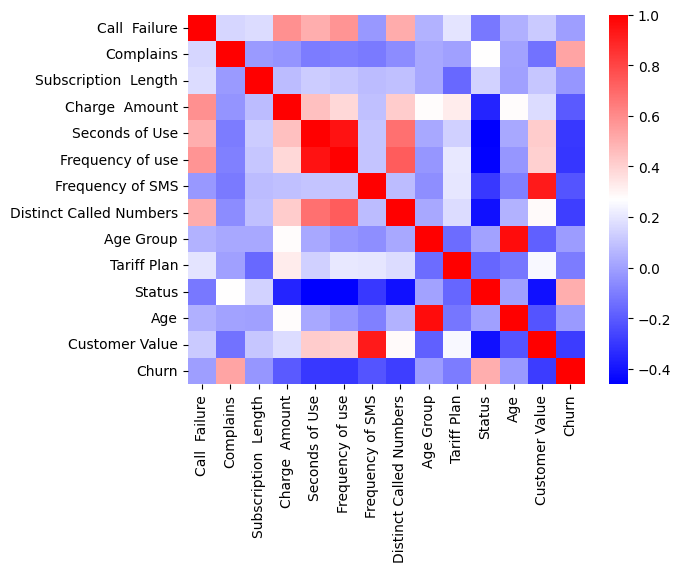

In [18]:
sns.heatmap(df.corr(),
            xticklabels=df.columns, yticklabels=df.columns,
            cmap = 'bwr')  

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


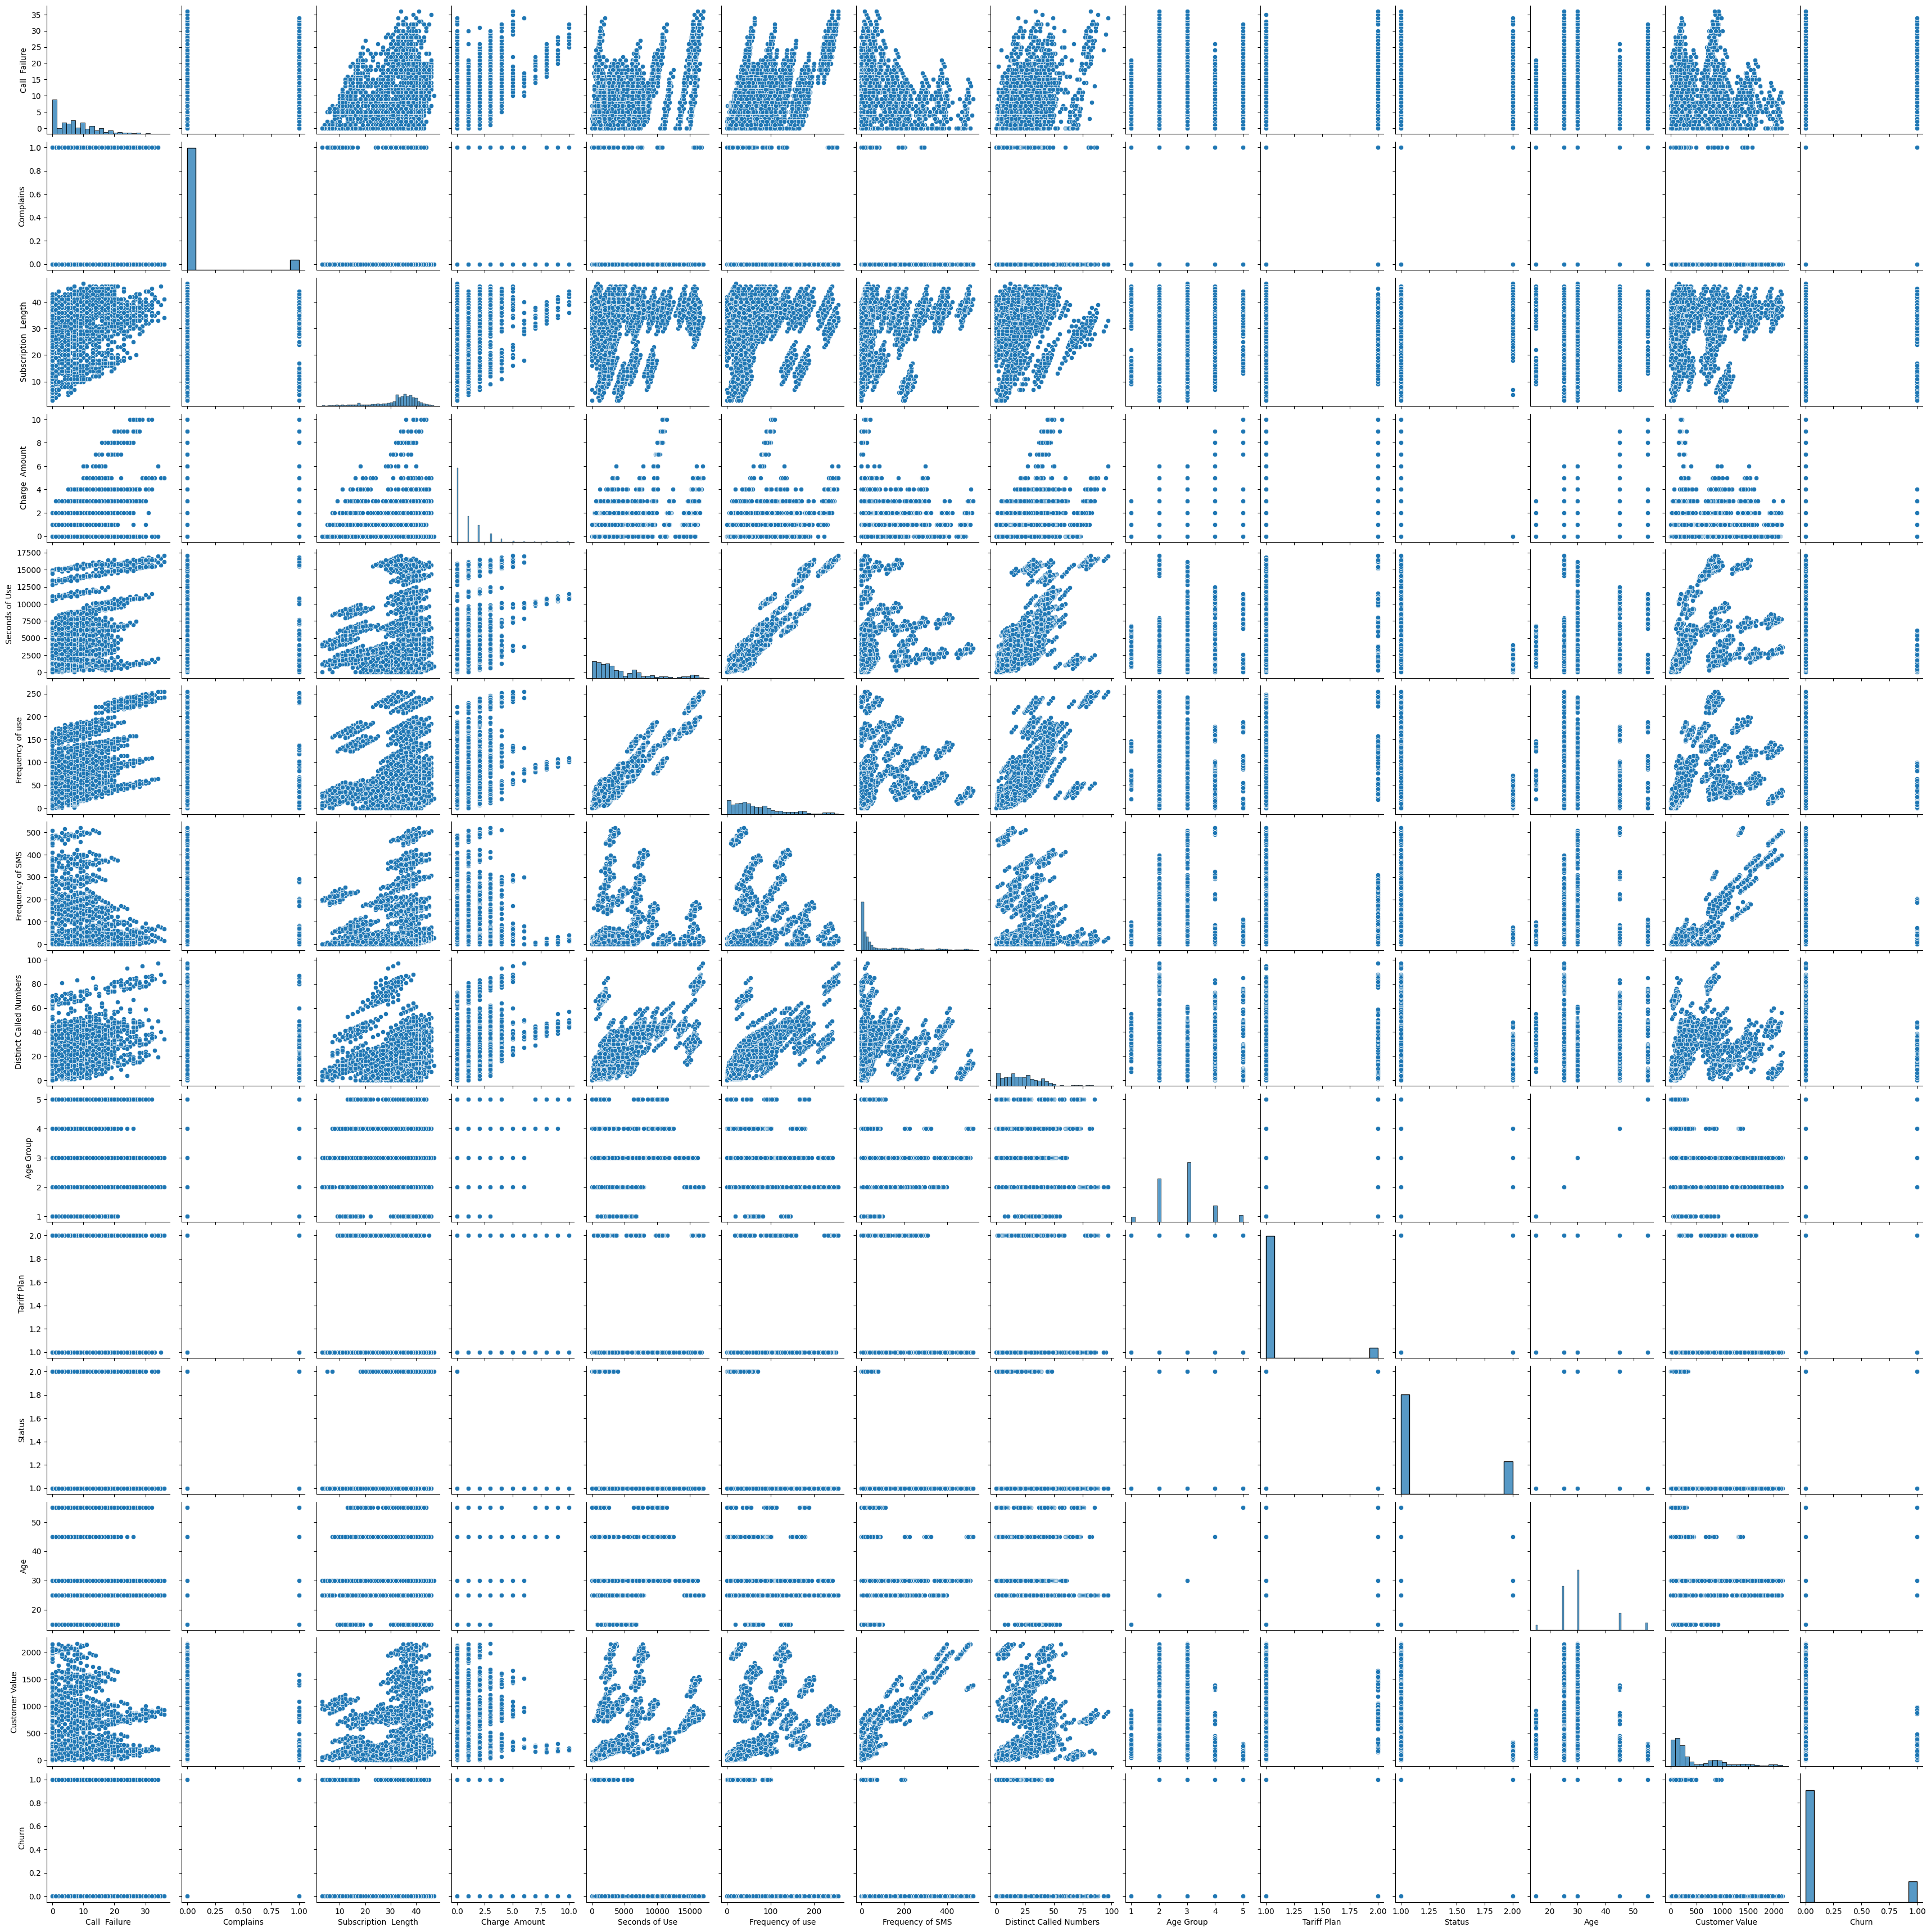

In [20]:
sns.pairplot(df)

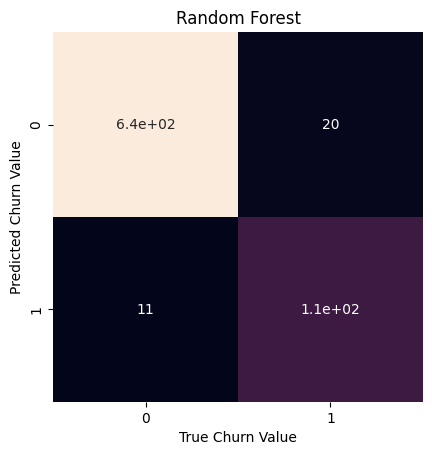

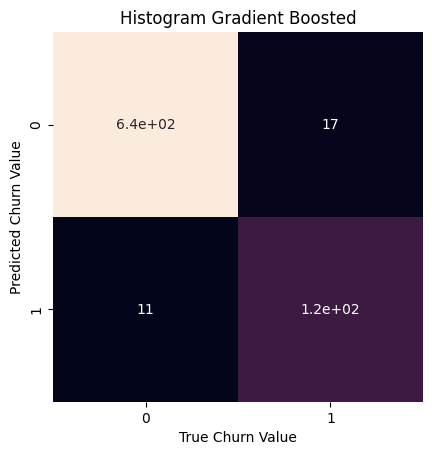

In [15]:
rf_conf = metrics.confusion_matrix(Ytest, RF_model.predict(Xtest))
hgbc_conf = metrics.confusion_matrix(Ytest, HGBC_model.predict(Xtest))

plot_confusion_mats(rf_conf.T, hgbc_conf.T)

In [16]:
plot_tree(RF_model)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(n_estimators=1000) instead.

In [ ]:
plot_tree(HGBC_model)